In [ ]:
"""
Choosing the radar volume from a Nexrad site over a time span.

Based on code by Scott Collis:
https://github.com/scollis/radar_in_the_cloud/blob/master/notebooks/Matthew.ipynb

Jonathan Helmus:
https://anaconda.org/jjhelmus/scipy2015_openaccessradar_jjh/notebook

and memory fixes by Robert Jackson:
https://github.com/rcjackson/pyart_practice/blob/master/nexrad_animatedgif.py

Note: NEXRAD s3 files are set in UTC.
"""

In [2]:
import boto
from boto.s3.connection import S3Connection
from datetime import timedelta, datetime
import os
import pyart
from matplotlib import pyplot as plt
import tempfile
import numpy as np
import cartopy


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
radarsite = 'KHGX'

base_date = "20150520_190000"
fmt = '%Y%m%d_%H%M%S' 

centerx = -95.3632700 #x-axis center of plot in degrees East
centery = 29.4718835 #y-axis center of plot in degrees North
zoom = 1.5 #plot zoom level

xm = 25/18 #plot x:y ratio

savelocation = '/home/scarani/Desktop/output/'

In [4]:
#Calculate nearest date and then pull the radar for the closests time
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data

    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    #Connect to the bucket

    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    #Get a list of files

    bucket_list = list(bucket.list(prefix = my_pref))

    #we are going to create a list of keys and datetimes to allow easy searching

    keys = []
    datetimes = []

    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    #print (radar.info())
    #my_radar.fields.keys()
    #my_radar.metadata['vcp_pattern']
    return radar

b_d = datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws(radarsite,b_d )
nyq = my_radar.instrument_parameters['nyquist_velocity']['data'].max()

In [5]:
#Plot Bounds
min_lon = centerx - (zoom*xm)
min_lat = centery - zoom
max_lon = centerx + (zoom*xm)
max_lat = centery + zoom

lal = np.arange(min_lat, max_lat, .5)
lol = np.arange(min_lon, max_lon, .5)


display = pyart.graph.RadarMapDisplayCartopy(my_radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]
proj = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

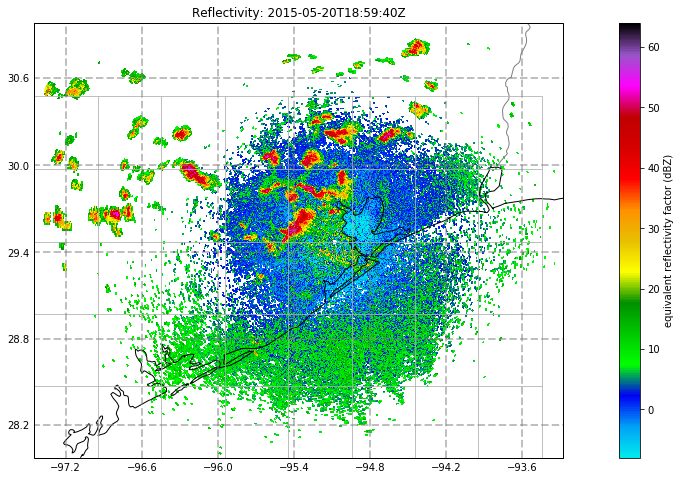

In [11]:
#Plot Relfectivity
fig = plt.figure(figsize = [20,8])
display.plot_ppi_map('reflectivity', sweep = 0, projection=proj, resolution = '10m',
                     vmin = -8, vmax = 64, mask_outside = False,
                     cmap = pyart.graph.cm.NWSRef,
                     min_lat = min_lat, min_lon = min_lon,
                     max_lat = max_lat, max_lon = max_lon,
                     lat_lines = lal, lon_lines = lol)
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('Reflectivity: ' + my_radar.time['units'].split()[2])
plt.savefig(savelocation + my_radar.time['units'].split()[2] +'-reflectivity.png', bbox_inches = 'tight', dpi = 300)

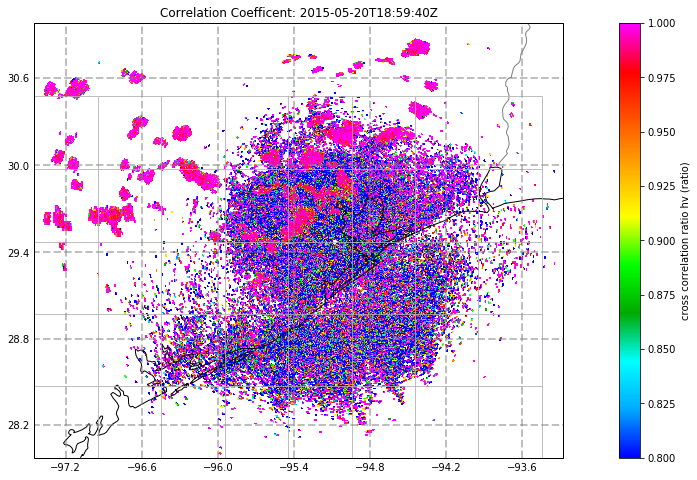

In [8]:
#Plot Correlation Coefficient
fig = plt.figure(figsize = [20,8])
display.plot_ppi_map('cross_correlation_ratio', sweep = 0, projection=proj, resolution = '10m',
                     vmin = .8, vmax = 1, mask_outside = False,
                     cmap = pyart.graph.cm.RefDiff,
                     min_lat = min_lat, min_lon = min_lon,
                     max_lat = max_lat, max_lon = max_lon,
                     lat_lines = lal, lon_lines = lol)
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('Correlation Coefficent: ' + my_radar.time['units'].split()[2])
plt.savefig(savelocation + my_radar.time['units'].split()[2] +'-correlation_coefficent.png', bbox_inches = 'tight', dpi = 300)

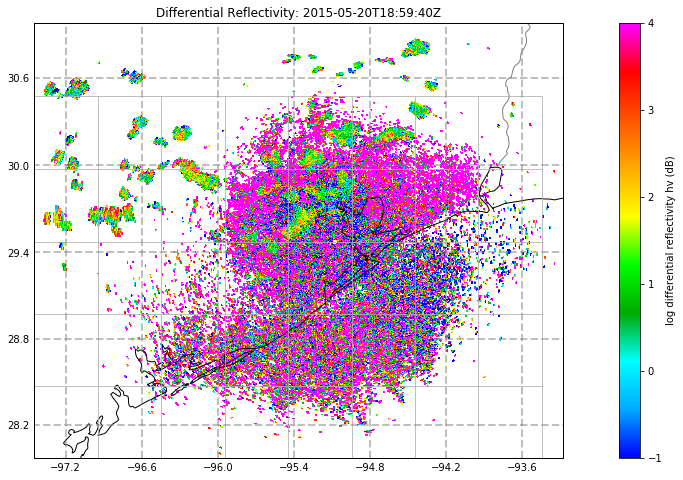

In [9]:
#Plot Differential Reflectivity
fig = plt.figure(figsize = [20,8])
display.plot_ppi_map('differential_reflectivity', sweep = 0, projection=proj, resolution = '10m',
                     vmin = -1, vmax = 4, mask_outside = False,
                     cmap = pyart.graph.cm.RefDiff,
                     min_lat = min_lat, min_lon = min_lon,
                     max_lat = max_lat, max_lon = max_lon,
                     lat_lines = lal, lon_lines = lol)
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('Differential Reflectivity: ' + my_radar.time['units'].split()[2])
plt.savefig(savelocation + my_radar.time['units'].split()[2] +'-differential_reflectivity.png', bbox_inches = 'tight', dpi = 300)

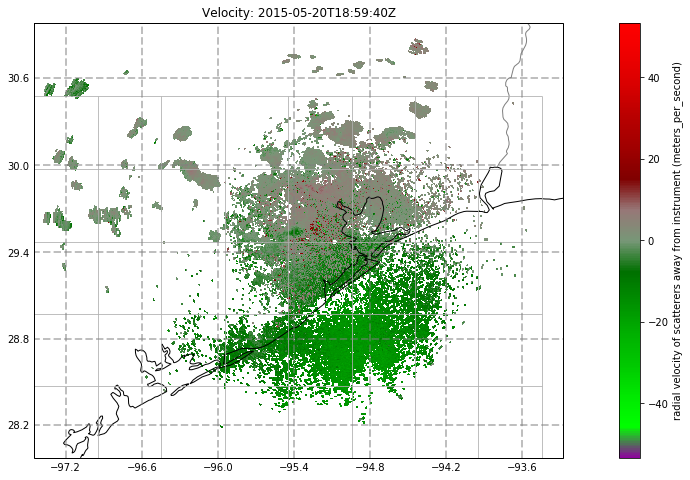

In [6]:
# Plot Velocity
fig = plt.figure(figsize = [20,8])
display.plot_ppi_map('velocity', sweep = 1, projection=proj, resolution = '10m',
                     vmin = -nyq*1.5, vmax = nyq*1.5, mask_outside = False,
                     cmap = pyart.graph.cm.NWSVel,
                     min_lat = min_lat, min_lon = min_lon,
                     max_lat = max_lat, max_lon = max_lon,
                     lat_lines = lal, lon_lines = lol)
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('Velocity: ' + my_radar.time['units'].split()[2])
plt.savefig(savelocation + my_radar.time['units'].split()[2] +'-velocity.png', bbox_inches = 'tight', dpi = 300)